In [1]:
!pip install -qU albumentations augraphy opencv-python

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spopt 0.6.0 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
ydata-profiling 4.6.4 requires numpy<1.26,>=1.16.0, but you have numpy 1.26.4 which is incompatible.


In [2]:
from PIL import Image
import cv2
import albumentations as A
import augraphy 
import random
import os
from pathlib import Path

In [3]:
val_images_list = list(Path("/kaggle/input/liver-ultrasound-detection/val/val/images").glob("*.jpg"))
train_images_list = list(Path("/kaggle/input/liver-ultrasound-detection/train/train/images").glob("*.jpg"))

# Visualize Val images

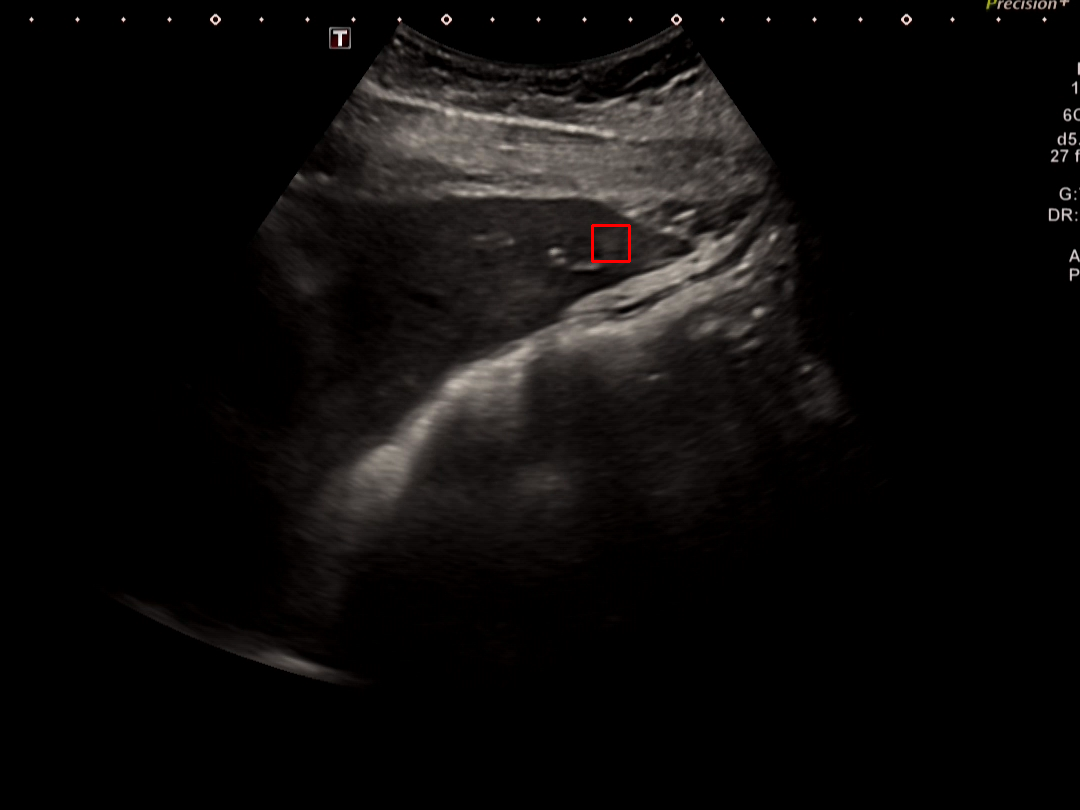

In [133]:
image_path = str(random.choice(val_images_list))
label_path = image_path.replace("images", "annotations").replace(".jpg", ".txt")

image = cv2.imread(image_path)
if os.path.exists(label_path):
    with open(label_path) as file:
        lines = file.readlines()

    for line in lines:
        class_id, x_center, y_center, width, height = line.split()
        class_id = int(float(class_id))
        bbox_x = int( (float(x_center) - float(width) / 2) * image.shape[1])
        bbox_y = int((float(y_center) - float(height) / 2) * image.shape[0])

        bbox_width = int(float(width) * image.shape[1])
        bbox_height = int(float(height) * image.shape[0])
        
        cv2.rectangle(image, (bbox_x, bbox_y), (bbox_x + bbox_width, bbox_y + bbox_height), (255, 0, 0), 2)
        
Image.fromarray(image)

# Define augmentations filter / function

In [184]:
lcdscreenpattern = augraphy.LCDScreenPattern(
    pattern_type="Vertical",
    pattern_value_range = (0,16),
    pattern_skip_distance_range = (3,5),
    pattern_overlay_method = "darken",
)

transform = A.Compose([
    A.RandomBrightnessContrast(
        brightness_limit=(0.05, 0.15),  # Union[float, Tuple[float, float]]
        contrast_limit=(-0.05, 0.05),  # Union[float, Tuple[float, float]]
        brightness_by_max=True,  # bool
        always_apply=False,  # bool
        p=1.0,  # float
    ),
    A.Perspective(
        scale=(0.05, 0.1),  # Union[float, Tuple[float, float]]
        keep_size=True,  # bool
        pad_mode=0,  # int
        pad_val=0,  # Union[float, Sequence[float]]
        mask_pad_val=0,  # Union[float, Sequence[float]]
        fit_output=False,  # bool
        interpolation=1,  # int
        always_apply=False,  # bool
        p=1.0,  # float
    ),
    A.MotionBlur(
        blur_limit=7,  # Union[int, Tuple[int, int]]
        allow_shifted=True,  # bool
        always_apply=False,  # bool
        p=0.3,  # float
    ),
    A.RandomScale(
        scale_limit=0.15,  # Union[float, Tuple[float, float]]
        interpolation=1,  # int
        always_apply=False,  # bool
        p=1.0,  # float
    )
], bbox_params=A.BboxParams(format='coco'))

moire = augraphy.Moire(
    moire_density = (15,20),
    moire_blend_method = "normal",
    moire_blend_alpha = 0.1,
)

def reflected_light(image):
    random_color = random.choice(
        [
            (255, 239, 212), 
            (255, 255, 255),
            (201, 231, 255),
            (196, 235, 255),
            (255, 250, 191)
        ]
    )
    
    edge = random.choice(["top-left", "top-right", "bottom-left", "bottom-right"])
    min_edge = 0.4
    add_edge = 0.6
    if edge == "top-left":
        pos = (random.random() * min_edge, random.random() * min_edge)
    elif edge == "top-right":
        pos = (random.random() * min_edge + add_edge, random.random() * min_edge)
    elif edge == "bottom-left":
        pos = (random.random() * min_edge, random.random() * min_edge + add_edge)
    elif edge == "bottom-right":
        pos = (random.random() * min_edge + add_edge, random.random() * min_edge + add_edge)
            
    function = augraphy.ReflectedLight(
        reflected_light_internal_radius_range=(0.0, 0.1),
        reflected_light_external_radius_range=(0.9, 1.0),
        reflected_light_color = random_color,
        reflected_light_internal_max_brightness_range=(0.5,0.7),
        reflected_light_external_max_brightness_range=(0.4,0.6),
        reflected_light_ellipse_angle_range = (0, 1),
        reflected_light_gaussian_kernel_size_range = (450, 700),
        reflected_light_location = pos
    )
    
    return function(image)

noise_texturize = augraphy.NoiseTexturize(
    sigma_range=(2, 3),
    turbulence_range=(2, 5),
    texture_width_range=(50, 500),
    texture_height_range=(50, 500),
)

shadowcast = augraphy.ShadowCast(
    shadow_side = "bottom",
    shadow_vertices_range = (2, 3),
    shadow_width_range=(0.5, 0.8),
    shadow_height_range=(0.5, 0.8),
    shadow_color = (0, 0, 0),
    shadow_opacity_range=(0.5,0.6),
    shadow_iterations_range = (1,2),
    shadow_blur_kernel_range = (101, 301),
)

def show_augment_result(image_path, label_path, bboxes):
    image = cv2.imread(image_path)

    moire_image = moire(image)
    image = cv2.addWeighted(moire_image, 0.27, image, 0.63, 0) 
    if random.random() < 0.35:
        image = noise_texturize(image)
    
    augmented = lcdscreenpattern(image)
    transformed = transform(image=augmented, bboxes=bboxes)
    
    return transformed

# Apply Augmentation

  0%|          | 0/50 [00:09<?, ?it/s]


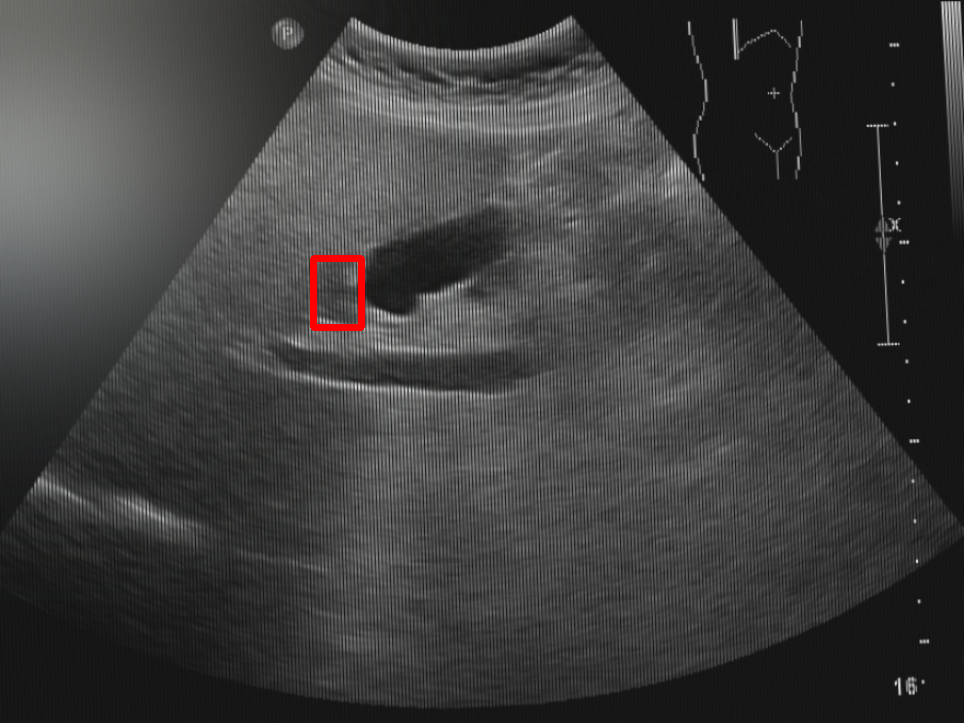

In [185]:
from tqdm import tqdm

samples_image_paths = list(set(random.choices(train_images_list, k=50)))

# images_list = []
# bboxes_list = []
for sample in tqdm(samples_image_paths):
    sample = str(sample)
    label_path = sample.replace("images", "annotations").replace(".jpg", ".txt")
    image = cv2.imread(sample)
    original_image = image.copy()
    
    bboxes = []
    if os.path.exists(label_path):
        with open(label_path) as file:
            lines = file.readlines()

        for line in lines:
            class_idx, xcenter, ycenter, w, h = map(float, line.split())
            xcenter *= image.shape[1]
            w *= image.shape[1]

            ycenter *= image.shape[0]
            h *= image.shape[0]

            x1, x2 = xcenter - w//2, xcenter + w//2
            y1, y2 = ycenter - h//2, ycenter + h//2
            x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])

            bboxes.append([x1, y1, w, h, class_idx])


    transformed = show_augment_result(sample, label_path, bboxes)
    new_bboxes = transformed['bboxes']
    image = transformed['image']
    
    for i in range(random.randint(1, 4)):
        image = reflected_light(image)
    
    if random.random() < 0.45:
        image = shadowcast(image)
        
    for bbox in new_bboxes:
        x, y, w, h, class_idx = map(int, bbox)
        cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 5)
    
    for bbox in bboxes:
        x, y, w, h, class_idx = map(int, bbox)
        cv2.rectangle(original_image, (x, y), (x + w, y + h), (255, 0, 0), 5)
    break

Image.fromarray(image)

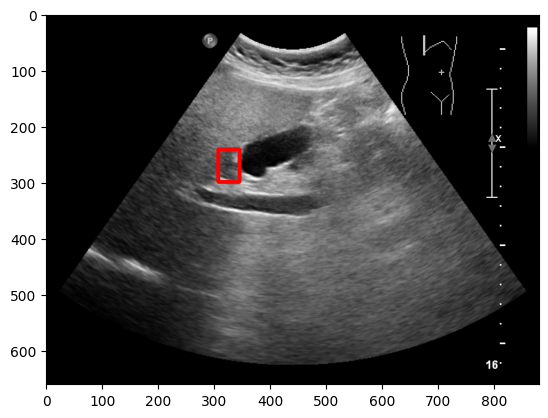

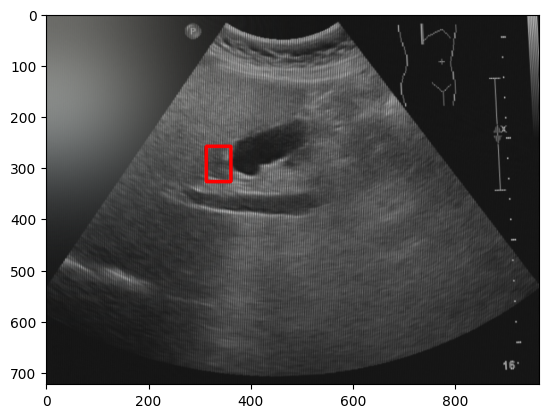

In [186]:
import matplotlib.pyplot as plt


plt.imshow(original_image)
plt.show()
plt.imshow(image)
plt.show()